# HQNSL for 1-qubit operations
This notebook is a test of the HQNSL scheme for the simplest parametrization of a quantum circuit: a set of `L` 1-qubit rotations given by `L * 3` parameters. We will learn in 2 bases and examine the effectiveness of the algorithm.

In [1]:
from __helpers import qubit_expansion, rand_basis
from __loss_funcs import KL
from __class_BasisTransformer import BasisTransformer
from __class_PQC import PQC
from __class_HQNet import HQNet
import matplotlib.pyplot as plt
import numpy as np
import torch as t
from math import pi
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import Statevector
%matplotlib inline

## Construction of the State

          ┌───┐                                        
q22321_0: ┤ H ├──■────■────■────■────■────■────■────■──
          └───┘┌─┴─┐  │    │    │    │    │    │    │  
q22321_1: ─────┤ X ├──┼────┼────┼────┼────┼────┼────┼──
               └───┘┌─┴─┐  │    │    │    │    │    │  
q22321_2: ──────────┤ X ├──┼────┼────┼────┼────┼────┼──
                    └───┘┌─┴─┐  │    │    │    │    │  
q22321_3: ───────────────┤ X ├──┼────┼────┼────┼────┼──
                         └───┘┌─┴─┐  │    │    │    │  
q22321_4: ────────────────────┤ X ├──┼────┼────┼────┼──
                              └───┘┌─┴─┐  │    │    │  
q22321_5: ─────────────────────────┤ X ├──┼────┼────┼──
                                   └───┘┌─┴─┐  │    │  
q22321_6: ──────────────────────────────┤ X ├──┼────┼──
                                        └───┘┌─┴─┐  │  
q22321_7: ───────────────────────────────────┤ X ├──┼──
                                             └───┘┌─┴─┐
q22321_8: ──────────────────────────────────────

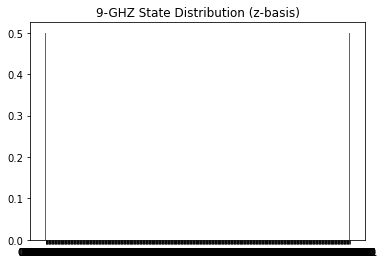

In [6]:
STATE_TYPE = 'GHZ'
NUM_QUBITS = 9
if STATE_TYPE == 'GHZ':
    # Prepare: GHZ State (from: Q-circuit)
    from GHZ_generator import GHZ_state_circuit
    state = Statevector.from_int(0, 2**NUM_QUBITS)
    qc = GHZ_state_circuit(L=NUM_QUBITS)
    print(qc)
    state = state.evolve(qc)
elif STATE_TYPE == 'XY':
    # Prepare: XY(L) (from: ED)
    from XY_generator import xy_ground_state
    state = Statevector(xy_ground_state(NUM_QUBITS).numpy())
elif STATE_TYPE == 'Cluster':
    # Prepare cluster(L) (from: Q-circuit)
    from cluster_generator import cluster_state_circuit
    state = Statevector.from_int(0, 2**(NUM_QUBITS**2))
    qc = cluster_state_circuit(3)
    print(qc)
    state = state.evolve(qc)
else:
    raise TypeError("Invalid state type specified.")

# Visualize the distribution
plt.bar(qubit_expansion(state.num_qubits), state.probabilities())
plt.title(f"{NUM_QUBITS}-{STATE_TYPE} State Distribution (z-basis)")
plt.show()

## HQN Training
We will construct the bases we want as a list of `L x 3` rotation-parameter matrices, then pass them into the hybrid quantum net and run the optimization algorithm. 

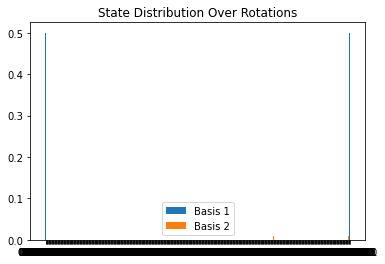

In [7]:
# Preparation of two bases
init_basis = t.zeros(state.num_qubits, 3) # z-basis
perturbation = init_basis.clone()
perturbation[:,0] += pi/10 * t.ones(state.num_qubits) # small rotation in one axis for each qubit
perturbed_basis = init_basis + perturbation
bases = [init_basis, perturbed_basis]
num_bases = len(bases)

# Visualize the distribution of the bases
fig, ax = plt.subplots()
for i, basis in enumerate(bases):
    dist_i = BasisTransformer([state], basis).updated_dist()[0]
    bar = ax.bar(np.arange(2**state.num_qubits) + 0.25*i - 0.04*state.num_qubits, dist_i, width=0.25)
    bar.set_label(f"Basis {i+1}")
plt.legend()
ax.set_xticks(np.arange(2**state.num_qubits))
ax.set_xticklabels(qubit_expansion(state.num_qubits))
plt.title("State Distribution Over Rotations")
plt.show()

In [8]:
# Start up the HQN
disp = False
hqn = HQNet(state, bases, eta=1e-3, maxiter=5000, disp=disp,
            mode='Nelder-Mead', 
            metric_func=KL, regularize=False)

Classical deep net initialized.
Classical deep net initialized.
Parametrized quantum circuit initialized.
Parametrized quantum circuit initialized.
9-qubit non-regularized 'Nelder-Mead' hybrid quantum net initialized -- Hello world!


In [9]:
# Optimize a few times.
NRUN = 5
param_dim = state.num_qubits * 3
proposed_syms = t.zeros((NRUN, param_dim)) #* parametrization-dependent
avg = 0
for i in range(NRUN):
    if disp:
        print(f"== Run {i+1}/{NRUN} ==")
    potential_sym, loss = hqn.find_potential_symmetry(print_log=True)
    proposed_syms[i] = potential_sym if t.is_tensor(potential_sym) else t.from_numpy(potential_sym)
    potential_sym = potential_sym.reshape((state.num_qubits, 3)) #* parametrization-dependent
    if disp:
        print(f"Proposed symmetry:\n{potential_sym}\n")
    avg += loss / NRUN
print(f"\nAverage loss: {avg}")

Optimized to QKL = 3.216886826362675e-11
Queried loss func 3673 times
Optimized to QKL = 2.4241015239567787e-07
Queried loss func 5001 times
Optimized to QKL = 0.0005005087587051094
Queried loss func 5000 times
Optimized to QKL = 2.84069500366968e-07
Queried loss func 5000 times
Optimized to QKL = 4.88598494996495e-08
Queried loss func 5000 times

Average loss: 0.00010021682607524799


### Summary of findings

We define `LA = A | B` to be the average loss `A` over `B` runs, throwing out extreme outliers. Times given are per run. The below results are for the 3-qubit GHZ state.

#### Local optimizers
1. Vanilla gradient descent is extremely slow (`~3 min`) and performs moderately poorly (`LA = 0.021 | 100`)
2. Adam is super fast (`<1 sec`) but performs very poorly (`LA = 3.77 | 1000`)
3. Nelder-Mead is very fast (`~5 sec`) and performs very well, needs `~1000` queries (`LA = 1e-14 | 100`).
4. Conjugate gradient is super fast (`<1 sec`) but performs very poorly (`LA = 3.171 | 1000`)
5. NFT is very fast (`~5 sec`) and performs well (`LA = 1e-5 | 100`).
6. SPSA is very slow (`~40 sec`) and performs reasonably well (`LA = 0.0036 | 100`)
7. TNC is extremely fast (`<<1 sec`) but performs very poorly (`LA = 3.62 | 1000`)
8. AQGD: I cannot get it to run. Seems like they are running some strange batch training which is not compatible
with my loss function `param_to_quantum_loss`. Too bad.

#### Global optimizers
1. TODO


In [10]:
# Look at the final KL divergence in each of the chosen bases.
for i, sym in enumerate(proposed_syms):
    if i > 0:
        print("\n")
    print(f"Analysing proposed symmetry {i+1}:\n{sym.reshape((state.num_qubits, 3))}\n")
    for basis_here in bases:
        loss_metric = PQC(state, basis_param=basis_here, metric_func=KL, say_hi=False).evaluate_true_metric(sym)
        print(f"\tLoss metric for training basis {basis_here[0]} is: {loss_metric}")

Analysing proposed symmetry 1:
tensor([[ 6.2832e+00,  2.4173e+00,  6.7348e+00],
        [ 6.1331e-06,  2.4369e+00,  5.0517e+00],
        [-6.9156e-05,  1.5636e+00,  7.0439e+00],
        [ 6.2832e+00,  1.4391e+00,  3.9390e+00],
        [ 6.7122e-06,  7.2677e+00,  4.2529e+00],
        [-5.0322e-07,  8.5129e+00,  8.0773e+00],
        [-1.6607e-06,  1.4607e+00,  9.1348e+00],
        [ 2.1286e-06,  1.8609e+00,  4.1844e+00],
        [-9.8396e-06,  4.7561e+00,  7.7614e+00]])

	Loss metric for training basis tensor([0., 0., 0.]) is: 3.5617133039152127e-12
	Loss metric for training basis tensor([0.3142, 0.0000, 0.0000]) is: 2.867207606646484e-11


Analysing proposed symmetry 2:
tensor([[3.1416, 2.4463, 4.1508],
        [3.1416, 0.1976, 1.3927],
        [3.1416, 0.6064, 5.7284],
        [3.1416, 0.4606, 3.8897],
        [3.1418, 1.5070, 2.8296],
        [3.1416, 2.2821, 0.5476],
        [3.1417, 1.6981, 5.4046],
        [3.1416, 0.0638, 5.2065],
        [3.1416, 3.5881, 6.6650]])

	Loss metric f

## Quantum Loss Cross-Validation
We chose a small number of bases to run the quantum loss scheme over. But are those bases enough? 
If the proposed symmetries are truly symmetries, then they will be a symmetry in every basis. We shall test
these proposed symmetries by choosing some random bases, applying the quantum circuit, and examining the loss metric there.

If the loss metric is high there, then we did not use enough bases in the quantum loss function.

Note that this has more general implications, as the number of bases necessary to achieve a good quantum loss function
informs the amount of information necessary to construct a reasonable tomography of the state.

In [11]:
# Choose some random bases to examine.
NUM_RAND_BASES = 3 # arbitrary
for i, sym in enumerate(proposed_syms):
    if i > 0:
        print("\n")
    print(f"Analysing proposed symmetry {i+1}:\n{sym.reshape((state.num_qubits, 3))}\n")
    for _ in range(NUM_RAND_BASES):
        basis_here = rand_basis(state.num_qubits)
        loss_metric = PQC(state, basis_param=basis_here, metric_func=KL, say_hi=False).evaluate_true_metric(sym)
        print(f"\tLoss metric for random basis {basis_here[0].numpy()} is: {loss_metric}")
    print('\n')

Analysing proposed symmetry 1:
tensor([[ 6.2832e+00,  2.4173e+00,  6.7348e+00],
        [ 6.1331e-06,  2.4369e+00,  5.0517e+00],
        [-6.9156e-05,  1.5636e+00,  7.0439e+00],
        [ 6.2832e+00,  1.4391e+00,  3.9390e+00],
        [ 6.7122e-06,  7.2677e+00,  4.2529e+00],
        [-5.0322e-07,  8.5129e+00,  8.0773e+00],
        [-1.6607e-06,  1.4607e+00,  9.1348e+00],
        [ 2.1286e-06,  1.8609e+00,  4.1844e+00],
        [-9.8396e-06,  4.7561e+00,  7.7614e+00]])

	Loss metric for random basis [5.315779  3.6870375 4.6666946] is: 0.00019891088810510538
	Loss metric for random basis [5.652077  1.8843696 2.1748104] is: 3.7141960033002422e-06
	Loss metric for random basis [3.401323  1.839191  2.8408055] is: 3.1321383211351005e-10




Analysing proposed symmetry 2:
tensor([[3.1416, 2.4463, 4.1508],
        [3.1416, 0.1976, 1.3927],
        [3.1416, 0.6064, 5.7284],
        [3.1416, 0.4606, 3.8897],
        [3.1418, 1.5070, 2.8296],
        [3.1416, 2.2821, 0.5476],
        [3.1417, 1.6